# Tulosten analysointi

Tässä projektin vaiheessa on tavoitteena optimoida edellissä vaiheessa luotuja kone- ja syväoppimismalleja ja analysoida tuloksia tarkemmin. Alkuperäisestä esikäsitellystä aineistosta eritellään 3 erillistä datasettiä Akuttomat ei-asuinkiinteistöihin asennetut järjestelmät(non_res_bat) jätetään pois sen pienen koon vuoksi. 

__Akulliset asuinkiinteistöihin asennetut järjestelmät__ -> res_bat

 - 6005 järjestelmää
 - Keskihinta: 37836 $
 
 
__Akulliset ei-asuinkiinteistöihin asennetut järjestelmät__ -> non_res
 
- 10743 järjestelmää
- Keskihinta: 111325 $

 


__Akuttomat asuinkiinteistöihin asennetut järjestelmät__ -> res
- 566899 järjestelmää
- Keskihinta: 24670 $
   
 



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
df = pd.read_csv("../data/base.csv", low_memory=False)


pd.options.display.max_columns = None


import warnings
warnings.filterwarnings('ignore')

In [2]:
# Muutetaan päivänmäärä pelkästään vuodeksi, koska scalerit eivät toimi datatimen kanssa
df["installation_date"] = pd.to_datetime(df['installation_date']).dt.year

df.shape

(602955, 30)

In [3]:


# Siivotaan datasta pois rivit missä hinta/DC suhde on alle 1000 tai yli 50000
df = df[(df["total_installed_price"] / df["system_size_DC"] >= 1000) & (df["total_installed_price"] / df["system_size_DC"] <= 50000)]

# Otetaan mukaan residential-järjestelmät, missä ei ole akkua
res = df[(df['residential'] == 1) & (df['battery'] == 0)]
# Otetaan mukaan residential-järjestelmät, missä on akku
res_bat = df[(df['residential'] == 1) & (df['battery'] == 1)]

# Otetaan mukaan non_residential-järjestelmät, missä ei ole akkua
non_res = df[(df['residential'] == 0) & (df['battery'] == 0)]
# Otetaan mukaan non_residential-järjestelmät, missä on akku
non_res_bat = df[(df['residential'] == 0) & (df['battery'] == 1)]


res = res.drop(columns=['battery', 'battery_rated_capacity_kW', 'residential'])
res_bat = res_bat.drop(columns=['battery', 'residential'])
non_res = non_res.drop(columns=['battery', 'battery_rated_capacity_kW', 'residential'])
non_res_bat = non_res_bat.drop(columns=['battery', 'residential'])

(590744, 30)

In [5]:
# Ladataan tarvittavia kirjastoja
from math import sqrt
from pandas import MultiIndex, Int16Dtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler, PowerTransformer
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import Pool, CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV

In [6]:
random_state = 42

# Tarkastelussa olevat algoritmit ja niille määritellyt default parametrit
models = {"RandomForest": RandomForestRegressor(random_state=random_state),
            "XGBoost": XGBRegressor(seed = random_state, tree_method="gpu_hist"),
            "CatBoost": CatBoostRegressor(random_seed = random_state, loss_function='RMSE', eval_metric ="MAE", verbose=False)
            }

In [7]:
# Alustetaan tarvittavia listoja
result_columns_list = ["Model","Scaler","RMSE train","RMSE test","R2 train","R2 test","MAE train","MAE test"] 
scalers_list = ["None", StandardScaler(), RobustScaler(), MinMaxScaler()]

In [47]:
def evaluate_models(df,scaler,models,importances=0):    


    # Jaetaan data treeni ja testi settiin 

    y = df["total_installed_price"]
    X = df.drop(columns="total_installed_price")

    features = X.columns

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state) 

    tulos = pd.DataFrame(columns=["Model","Scaler","RMSE train","RMSE test","R2 train","R2 test","MAE train","MAE test"])
    
    # Skaalataan data funktiokutsussa ilmoitetulla skaalaajalla

    if scaler != "None":

        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=features)
        X_test = pd.DataFrame(scaler.transform(X_test), columns=features)        


    # Sovitetaan data mallille ja määritellään RMSE, R2 ja MAE testi- ja treeni-seteille ja tallennetaan ne dataframeen

    for name, model in models.items():
        

        model.fit(X_train,y_train)

        

        RMSE_test = sqrt(mean_squared_error(y_test, model.predict(X_test)))
        RMSE_train = sqrt(mean_squared_error(y_train, model.predict(X_train)))
        r2_test = r2_score(y_test, model.predict(X_test))
        r2_train = r2_score(y_train, model.predict(X_train))
        MAE_test = mean_absolute_error(y_test, model.predict(X_test))
        MAE_train = mean_absolute_error(y_train, model.predict(X_train))

        tulos.loc[len(tulos)] = [name,scaler,RMSE_train,RMSE_test,r2_train,r2_test,MAE_train,MAE_test]

    
        # Jos importances == 1 käsitellään dataframen feature_importances ja piirretään niistä kuvaajat
        if importances == 1:
            importances = model.feature_importances_
            sorted_importances = np.argsort(importances)[::-1]
            plt.figure(figsize=(10,10))
            plt.barh(X.columns[sorted_importances], importances[sorted_importances])
            plt.title(f"{name} Feature Importance")
            plt.show()
            tulos = ""
        
    
    return tulos

In [9]:
# Funktio, millä voidaan siivota poikkeamat pois datasetistä käyttäen IQR-menetelmää

def exception_handling(df, battery = 0):

    print("Alkuperäisen DataFramen koko = ",df.shape)

    # Käytetään akullisille jäjestelmille pienempää feature-listaa, koska muuten dataframe menee tyhjäksi!
    if battery == 1:

        features = ['system_size_DC', 'total_installed_price','inverter_loading_ratio', 'module_quantity','module_efficiency', 'inverter_total_capacity']
    else:
        features = ['system_size_DC', 'total_installed_price',        
                'inverter_loading_ratio', 'module_quantity','module_efficiency',
                'inverter_quantity', 'inverter_total_capacity']

    for col in features:

            alaraja, ylaraja = np.percentile(a=df[col], q=[25,75])
            iqr = ylaraja - alaraja
            #print((f"{col} Alaraja = {alaraja} Yläraja = {ylaraja} IQR = {iqr}"))

            # Tehdään uudet yla- ja alarajat missä mukana 1.5*IQR

            alaraja_iqr = alaraja - 1.5*iqr
            ylaraja_iqr = ylaraja + 1.5*iqr

            df = df[(df[col] > alaraja_iqr) & (df[col] < ylaraja_iqr)]
    
    print("Siivotun DataFramen koko = ",df.shape)        
    print("Keskihinta = ",df["total_installed_price"].mean())

    return df

In [10]:
# Funktio jolla voi piirtää kuvaajat dataseteistä

def draw_graph(df):

    df = df.sort_values("Model")

    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.title("Mean absolute error testset")
    sns.barplot(data=df,x ="Model", y="MAE test",hue="Scaler")
    plt.xticks(rotation=45,ha="right")
    plt.legend(loc='lower right')
    plt.subplot(1,2,2)
    plt.title("R2 score testset")
    sns.barplot(data=df,x ="Model", y="R2 test",hue="Scaler")
    plt.xticks(rotation=45,ha="right")
    plt.legend(loc='lower right')
    plt.show()


In [11]:
# Funktio, joka kutsuu aikaisemmat funktiot ja tulostaa tulokset

def print_results(df,models,scalers=scalers_list,result_columns=result_columns_list, battery=0, importances = 0):
    result_df = pd.DataFrame(columns=result_columns)

    # Siivotaan poikkeukset
    df_clean = exception_handling(df, battery)

    # Ajetaan eri skaalaajat evaluate_models funktion läpi
    for scaler in scalers:
        data = evaluate_models(df_clean,scaler,models, importances)
        result_df = result_df.append(data).sort_values(["R2 test","MAE test", "Model"],ascending=False)
        
    # Piirretään kuvaaja
    draw_graph(result_df)


    return result_df

In [12]:
# Funktio, jolla voi optimoida algoritmien hyperparamettereita

def hyperparameters_optimizer(df, model, param_grid, exceptions=0):

        # Siivotaan poikkeamat
        if exceptions == 0:
                df = exception_handling(df)
        
        y = df["total_installed_price"]
        X = df.drop(columns="total_installed_price")

        # Alustetaan RandomizedSearchCV
        grid = RandomizedSearchCV(
                model,
                param_grid,
                n_iter=25, scoring='neg_mean_squared_error', verbose=1)

        # Sovitetaan data RandomizedSearchCV funktiolle
        grid.fit(X,y)

        # Tulostetaan parhaat parametrit
        return grid.best_params_
    

## Otsikko


Edellisen vaiheen koneoppimismallien esikarsinnan tuloksena valikoitui 3 algoritmia: __RandomForest__, __CatBoost__, ja __XGBoost Regressor__. Kaikki näistä ovat päätöspuihin perustuvia algoritmeja. Päätöspuut ovat tehokkaita käytettynä koneoppimisessa ja niitä voidaan käyttää monimutkaisiin aineistoihin ja ne sopivat myös regressiotehtäviin, joten ne soveltuvat hyvin tämän projektin datasettiin, joka sisältää numeerisia-, boolean- ja kategorisia muuttujia.

Gradienttitehostetut päätöspuut yhdistävät useita päätöspuita ennusteen tekemiseksi. Jokainen uusi päätöspuu yrittää tehostaa edellisen tuloksia. __XGBoost__ ja __CatBoost__ ovat tähän menetelmään perustuvia algoritmeja. Niitä on useassa lähteessä kehuttu erittäin tehokkaiksi ja nopeiksi algoritmeiksi verrattuna muihin samantyyppisiin algoritmeihin. 

__RandomForest__ eli satunnaismetsä kouluttaa jokaisen päätöspuun itsenäisenä yksikkönä satunnaisella näytteellä datasta. Satunnaisuuden vuoksi mallissa ei tapahdu niin helposti ylioppimista.




### Poikkeamat ja skaalaus
Poistetaan dataseteistä poikkeamat IQR-menetelmää(interquartile range) käyttäen. Data skaalautuu 25-75% kvartiilien väliin. Data skaalataan 3:lla eri menetelmällä ja lisäksi ilman skaalausta. Yllättävästi erityyppiset skaalausmenetelemät tuntuvat vaikuttavan tuloksiin ja siksi datasetit ajetaan vielä eri menetelmillä skaalattuna mallin läpi. Näin saadaan sekoitettua datasettejä, scalereita, hyperparametri-optimointeja ja koneoppimisalgoritmeja keskenään ja mahdollisesti löytää tällä menetelmällä optimaalisin kokoonpano.


### Hyperparametrit
Koneoppimismallien hyperparametrit optimoidaan RandomizedSearchCV-algoritmilla. Datasetit ajetaan mallien läpi ennen ja jälkeen optimoinnin, ja vaikutuksia tuloksiin vertaillaan.


#### RandomizedSearchCV:n  ehdotukset:

[optimointi-funktiot eri tiedostoon?]

- RandomForest: dataset = res.sample(50000), runtime= n. 6h, runtime koko dataset yli 13h

    - {'n_estimators': 1000,
    - 'min_samples_split': 4,
    - 'min_samples_leaf': 2,
    - 'max_features': 'auto',
    - 'max_depth': 10,
    - 'bootstrap': True}

- CatBoostRegressor: dataset = res, runtime = n. 17min
    - {'subsample': 0.5,
    - 'learning_rate': 0.3,
    - 'l2_leaf_reg': 10,
    - 'iterations': 1000,
    - 'depth': 10,
    - 'border_count': 200}

- XGBRegressor: dataset = res, runtime = n. 3h
    - {'subsample': 0.8999999999999999,
    - 'n_estimators': 2000,
    - 'max_depth': 6,
    - 'learning_rate': 0.1,
    - 'colsample_bytree': 0.7,
    - 'colsample_bylevel': 0.8999999999999999}


### Tulosten analysoinnissa käytetyt metriikat 

- RMSE = Root Mean Square Error. Keskineliövirheen neliöjuuri antaa normalisoidun etäisyyden ennustettujen arvojen vektorin ja pohjatotuutena olevan vektorin välillä. 
- R2 = R squared. R2-luku kertoo kuinka hyvin malli sovittuu regressiomalleissa opetusaineistoon. R2-luku kertoo kuinka suuren osuuden mallin muuttujat voivat selittää pohjatotuudesta.
- MAE = Mean absolute error.  Keskimääräinen absoluuttinen virhe antaa numeerisen arvon, joka kertoo kuinka paljon algoritmin tekemä arvio keskimäärin erosi pohjatotuudesta. 



## Ajot(parempi otsikko tähän)

Seuraavassa osuudessa ajetaan jokainen datasetti mallien läpi ensin ilman hyperparametrien optimointia ja sitten optimoinnin jälkeen ja vertaillaan tuloksia
<br>


## Otsikko


Edellisen vaiheen koneoppimismallien esikarsinnan tuloksena valikoitui 3 algoritmia: __RandomForest__, __CatBoost__, ja __XGBoost Regressor__. Kaikki näistä ovat päätöspuihin perustuvia algoritmeja. Päätöspuut ovat tehokkaita käytettynä koneoppimisessa ja niitä voidaan käyttää monimutkaisiin aineistoihin ja ne sopivat myös regressiotehtäviin, joten ne soveltuvat hyvin tämän projektin datasettiin, joka sisältää numeerisia-, boolean- ja kategorisia muuttujia.

Gradienttitehostetut päätöspuut yhdistävät useita päätöspuita ennusteen tekemiseksi. Jokainen uusi päätöspuu yrittää tehostaa edellisen tuloksia. __XGBoost__ ja __CatBoost__ ovat tähän menetelmään perustuvia algoritmeja. Niitä on useassa lähteessä kehuttu erittäin tehokkaiksi ja nopeiksi algoritmeiksi verrattuna muihin samantyyppisiin algoritmeihin. 

__RandomForest__ eli satunnaismetsä kouluttaa jokaisen päätöspuun itsenäisenä yksikkönä satunnaisella näytteellä datasta. Satunnaisuuden vuoksi mallissa ei tapahdu niin helposti ylioppimista.




### Poikkeamat ja skaalaus
Poistetaan dataseteistä poikkeamat IQR-menetelmää(interquartile range) käyttäen. Data skaalautuu 25-75% kvartiilien väliin. Data skaalataan 3:lla eri menetelmällä ja lisäksi ilman skaalausta. Yllättävästi erityyppiset skaalausmenetelemät tuntuvat vaikuttavan tuloksiin ja siksi datasetit ajetaan vielä eri menetelmillä skaalattuna mallin läpi. Näin saadaan sekoitettua datasettejä, scalereita, hyperparametri-optimointeja ja koneoppimisalgoritmeja keskenään ja mahdollisesti löytää tällä menetelmällä optimaalisin kokoonpano.


### Hyperparametrit
Koneoppimismallien hyperparametrit optimoidaan RandomizedSearchCV-algoritmilla. Datasetit ajetaan mallien läpi ennen ja jälkeen optimoinnin, ja vaikutuksia tuloksiin vertaillaan.


#### RandomizedSearchCV:n  ehdotukset:

[optimointi-funktiot eri tiedostoon?]

- RandomForest: dataset = res.sample(50000), runtime= n. 6h, runtime koko dataset yli 13h

    - {'n_estimators': 1000,
    - 'min_samples_split': 4,
    - 'min_samples_leaf': 2,
    - 'max_features': 'auto',
    - 'max_depth': 10,
    - 'bootstrap': True}

- CatBoostRegressor: dataset = res, runtime = n. 17min
    - {'subsample': 0.5,
    - 'learning_rate': 0.3,
    - 'l2_leaf_reg': 10,
    - 'iterations': 1000,
    - 'depth': 10,
    - 'border_count': 200}

- XGBRegressor: dataset = res, runtime = n. 3h
    - {'subsample': 0.8999999999999999,
    - 'n_estimators': 2000,
    - 'max_depth': 6,
    - 'learning_rate': 0.1,
    - 'colsample_bytree': 0.7,
    - 'colsample_bylevel': 0.8999999999999999}


### Tulosten analysoinnissa käytetyt metriikat 

- RMSE = Root Mean Square Error. Keskineliövirheen neliöjuuri antaa normalisoidun etäisyyden ennustettujen arvojen vektorin ja pohjatotuutena olevan vektorin välillä. 
- R2 = R squared. R2-luku kertoo kuinka hyvin malli sovittuu regressiomalleissa opetusaineistoon. R2-luku kertoo kuinka suuren osuuden mallin muuttujat voivat selittää pohjatotuudesta.
- MAE = Mean absolute error.  Keskimääräinen absoluuttinen virhe antaa numeerisen arvon, joka kertoo kuinka paljon algoritmin tekemä arvio keskimäärin erosi pohjatotuudesta. 



## Ajot(parempi otsikko tähän)

Seuraavassa osuudessa ajetaan jokainen datasetti mallien läpi ensin ilman hyperparametrien optimointia ja sitten optimoinnin jälkeen ja vertaillaan tuloksia
<br>

### RES-BAT
    
Poikkeamien poiston jälkeen
 - 4307 järjestelmää
 
 - Keskihinta: 34613 $ 


#### Optimoimaton RES-BAT

Alkuperäisen DataFramen koko =  (6057, 28)
Siivotun DataFramen koko =  (4416, 28)
Keskihinta =  34552.197284873124


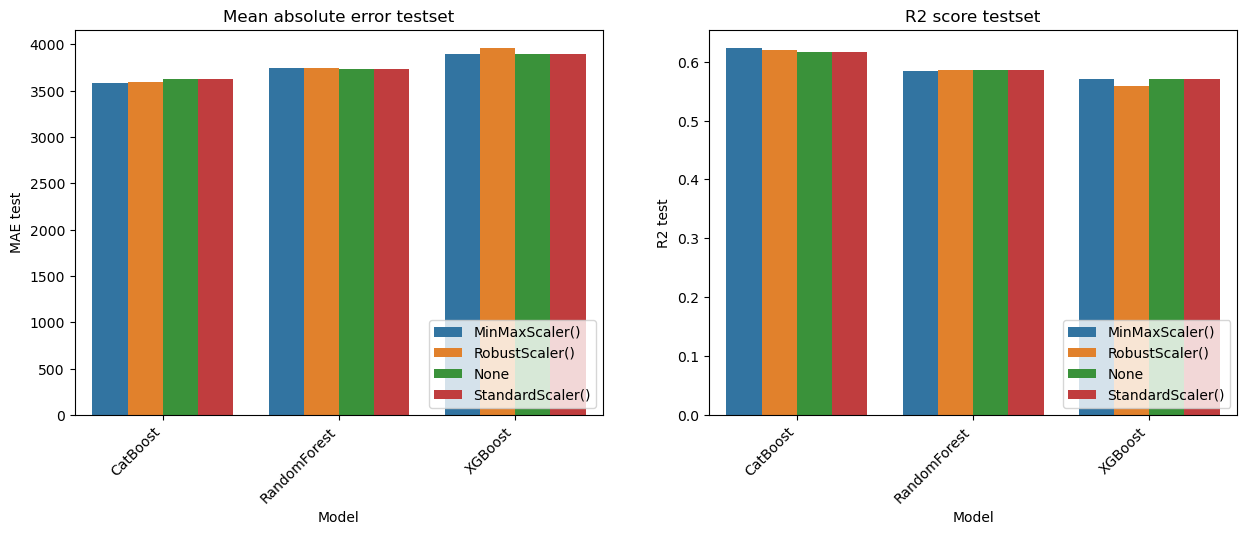

,Model,Scaler,RMSE train,RMSE test,R2 train,R2 test,MAE train,MAE test
2,CatBoost,MinMaxScaler(),3310.607391,5676.138437,0.874833,0.623115,2284.151072,3581.035149
2,CatBoost,RobustScaler(),3328.831458,5697.540973,0.873451,0.620268,2289.284807,3589.866451
2,CatBoost,None,3366.071771,5729.322910,0.870603,0.616020,2316.333736,3623.078517
2,CatBoost,StandardScaler(),3366.071771,5729.802830,0.870603,0.615955,2316.333736,3623.779141
0,RandomForest,StandardScaler(),2378.053129,5948.509634,0.935417,0.586078,1497.145237,3734.741520
0,RandomForest,RobustScaler(),2378.844856,5949.806536,0.935374,0.585897,1497.447730,3740.889977
0,RandomForest,None,2379.412240,5950.450306,0.935343,0.585808,1497.536379,3735.962969
0,RandomForest,MinMaxScaler(),2382.343353,5955.515629,0.935184,0.585102,1499.298038,3741.150983
1,XGBoost,None,1721.912125,6055.552299,0.966139,0.571047,1145.472830,3900.304123
1,XGBoost,StandardScaler(),1721.912125,6055.552299,0.966139,0.571047,1145.472830,3900.304123


In [13]:
res_bat_result = print_results(res_bat, models, battery=1)
res_bat_result

In [14]:
res_bat_result.describe().T

,count,mean,std,min,25%,50%,75%,max
RMSE train,12.0,2486.241105,689.933214,1721.912125,1764.668718,2379.128548,3315.163407,3366.071771
RMSE test,12.0,5911.696948,161.413891,5676.138437,5729.682850,5950.128421,6055.552299,6136.619226
R2 train,12.0,0.924424,0.040567,0.870603,0.874487,0.935358,0.964430,0.966139
R2 test,12.0,0.590906,0.022231,0.559485,0.571047,0.585852,0.615971,0.623115
MAE train,12.0,1652.294657,501.209437,1145.472830,1181.558206,1497.492054,2285.434506,2316.333736
MAE test,12.0,3752.507706,134.187028,3581.035149,3623.603985,3738.426473,3900.304123,3958.675390


RES-BAT datasetin default-hyperparametreillä parhaiten suoritui parhaiten CatBoost RobustScalerilla skaalattuna, antaen opetusaineistolle MAE-arvon 2100 ja R2-scoren 0.89. Testiaineistolle vastaavat arvot olivat MAE 3753 ja R2 0.60.

Huonoimman ja parhaimman algortimin ero oli MAE 349, R2 0.07 Kaikilla algoritmeillä opetusaineiston R2-score oli huomattavasti suurempi kuin testiaineiston R2. Suurin ero 0.45 ja pienin ero 0.28. Tästä voidaan päätellä, että kaikki mallit olivat ylioppineita. Yksi mahdollinen syy tähän voi olla datasetin pieni koko.




#### Optimoitu RES-BAT

Alkuperäisen DataFramen koko =  (6057, 28)
Siivotun DataFramen koko =  (4416, 28)
Keskihinta =  34552.197284873124


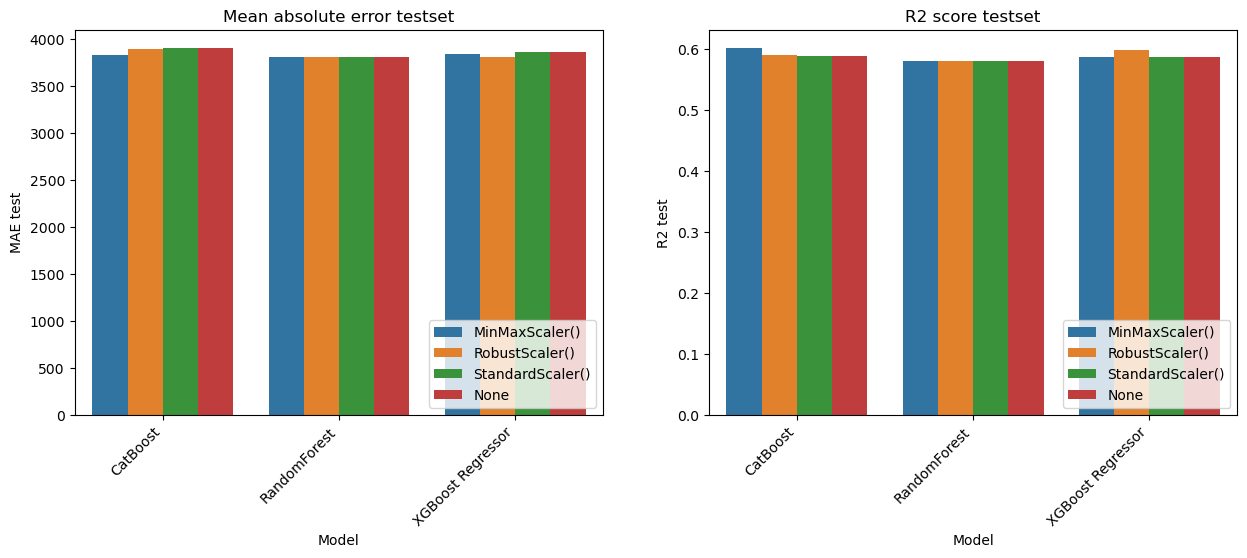

,Model,Scaler,RMSE train,RMSE test,R2 train,R2 test,MAE train,MAE test
1,CatBoost,MinMaxScaler(),306.547798,5841.323133,0.998927,0.600860,152.191444,3826.433160
2,XGBoost Regressor,RobustScaler(),202.763998,5860.617287,0.999530,0.598219,27.615733,3809.965386
1,CatBoost,RobustScaler(),276.221284,5917.919229,0.999129,0.590324,126.415582,3894.793072
1,CatBoost,StandardScaler(),301.005546,5937.940430,0.998965,0.587547,147.713792,3900.813507
1,CatBoost,None,301.005546,5938.422464,0.998965,0.587480,147.713792,3901.545417
2,XGBoost Regressor,MinMaxScaler(),203.233296,5946.234432,0.999528,0.586394,29.315770,3840.579791
2,XGBoost Regressor,None,203.183980,5951.280649,0.999529,0.585692,29.168787,3856.125092
2,XGBoost Regressor,StandardScaler(),203.183980,5951.280649,0.999529,0.585692,29.168787,3856.125092
0,RandomForest,RobustScaler(),4109.947993,5987.171370,0.807093,0.580680,2717.138020,3810.748420
0,RandomForest,StandardScaler(),4109.796694,5988.624669,0.807107,0.580476,2717.099995,3810.617960


In [19]:
res_bat_result_optimal = print_results(res_bat, models_tuned, battery=1)
res_bat_result_optimal

In [20]:
res_bat_result_optimal.describe().T

,count,mean,std,min,25%,50%,75%,max
RMSE train,12.0,1536.392890,1901.083061,202.763998,203.220967,301.005546,4109.820389,4109.947993
RMSE test,12.0,5941.585118,48.811415,5841.323133,5932.935130,5948.757541,5987.534695,5989.224023
R2 train,12.0,0.935208,0.094616,0.807093,0.807105,0.998965,0.999528,0.999530
R2 test,12.0,0.587015,0.006760,0.580392,0.580629,0.586043,0.588241,0.600860
MAE train,12.0,963.201674,1296.408988,27.615733,29.279024,147.713792,2717.109501,2717.445055
MAE test,12.0,3844.132181,37.295502,3809.965386,3810.715805,3833.506475,3865.792087,3901.545417


Hyperparametrioptimoiduilla algoritmeillä parhaiten suoritui RandomForest ilman skaalausta, MAE train 2612, R2 0.813. MAE test 3947, R2 0.544. Hyperparametrien tuunauksella RandomForestin R2 train ja test arvojen erotus pieneni, eli malli geneerisempi verrattuna aikaisempaan. 

Yllättävästi hyperparametrituunaus huononsi tuloksia ja aiheutti sen, että CatBoost ja XGBoost olivat täysin ylioppineita. Syynä voi olla, että hyperparametrioptimointi tehtiin käyttämällä suurempaa RES-datasettiä, joten hyperparametrien arvot eivät välttämättä toimi hyvin pienemmissä dataseteissä.

MAE test nousi keskimäärin 63 USD. R2-score pysyi keskimäärin samana mutta suurin arvo tippui 3,5 %.


<br><br><br>

### NON-RES

Poikkeamien poiston jälkeen

- 5894 järjestelmää

- Keskihinta 111325 $

#### Optimoimaton NON-RES

Alkuperäisen DataFramen koko =  (11012, 27)
Siivotun DataFramen koko =  (6028, 27)
Keskihinta =  113145.6833012608


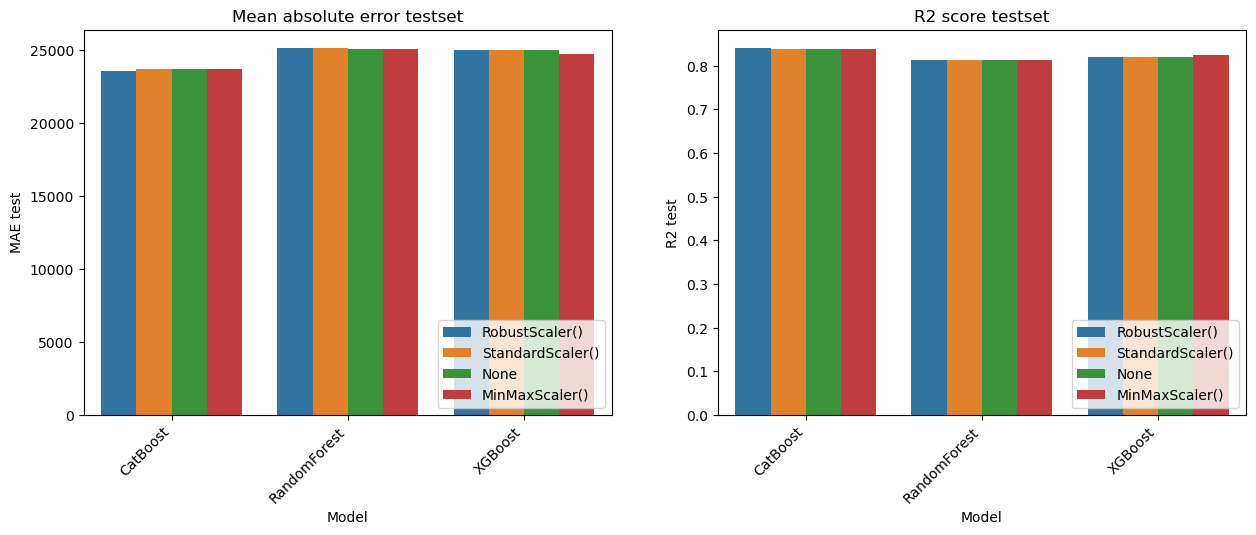

,Model,Scaler,RMSE train,RMSE test,R2 train,R2 test,MAE train,MAE test
2,CatBoost,RobustScaler(),22818.646846,45245.886468,0.958769,0.839754,13878.567114,23573.450378
2,CatBoost,StandardScaler(),22647.511443,45438.727934,0.959385,0.838385,13733.008860,23689.431428
2,CatBoost,None,22647.511443,45439.104416,0.959385,0.838382,13733.008860,23690.626688
2,CatBoost,MinMaxScaler(),22689.284785,45459.079499,0.959235,0.838240,13738.955704,23697.108822
1,XGBoost,MinMaxScaler(),11181.343256,47343.797998,0.990100,0.824549,7000.236060,24763.552776
1,XGBoost,None,10745.112009,47905.247475,0.990857,0.820363,6781.999754,24973.581982
1,XGBoost,StandardScaler(),10745.112009,47905.247475,0.990857,0.820363,6781.999754,24973.581982
1,XGBoost,RobustScaler(),10745.112009,47905.247475,0.990857,0.820363,6781.999754,24973.581982
0,RandomForest,MinMaxScaler(),18072.006632,48898.045629,0.974138,0.812840,9582.205554,25087.079062
0,RandomForest,StandardScaler(),18079.899160,48964.070575,0.974115,0.812334,9574.547302,25132.314186


In [21]:
non_res_result = print_results(non_res, models)
non_res_result

In [22]:
non_res_result.describe().T

,count,mean,std,min,25%,50%,75%,max
RMSE train,12.0,17210.498346,5093.184362,10745.112009,11072.285444,18075.952896,22647.511443,22818.646846
RMSE test,12.0,47369.718770,1550.740702,45245.886468,45454.085728,47905.247475,48914.551865,48967.450878
R2 train,12.0,0.974662,0.013429,0.958769,0.959385,0.974127,0.990289,0.990857
R2 test,12.0,0.824184,0.011433,0.812308,0.812713,0.820363,0.838275,0.839754
MAE train,12.0,10062.452208,2979.000955,6781.999754,6945.676983,9578.376428,13733.008860,13878.567114
MAE test,12.0,24565.099226,674.471586,23573.450378,23695.488288,24973.581982,25090.878870,25132.314186


Default-hyperparametreillä NON-RES-datasetillä parhaiten suoriutui CatBoost MinMaxScalerilla. MAE train oli 11026, R2 train 0.976, MAE test 20672, R2 test 0.88.  Tässä datasetissä tulokset olivat jo selvästi parempia, mutta mallit olivat silti lievästi ylioppineita. R2 train keskimäärin oli 0.984 ja R2 test oli keskimäärin 0.874. 

Tämä datasetti oli edellisen tapaan melko pieni, mutta tässä tässä ennustusten tarkkuus R2-scorella mitattuna on huomattavasti parempi kuin edellisessä RES-BAT-datasetissä. Arvelimme edellisen datasetin huonojen tulosten johtuvan datasetin koosta, mutta ehkä kyse on jostakin muusta ongelmasta, kuten esimerkiksi datarakenteesta.

Parhaimmillan R2-scoren arvon ollessa 0.88, tulokset tämän perusteella olivat erittäin hyvät, mutta MAE:n ollessa 20672 päädyttiin n. 20% virheeseen keskihintaan nähden. Tämä tuntuu liian suurelta, jotta malli voisi antaa riittävän tarkkoja ennustuksia.   






#### Optimoitu NON-RES

Alkuperäisen DataFramen koko =  (11012, 27)
Siivotun DataFramen koko =  (6028, 27)
Keskihinta =  113145.6833012608


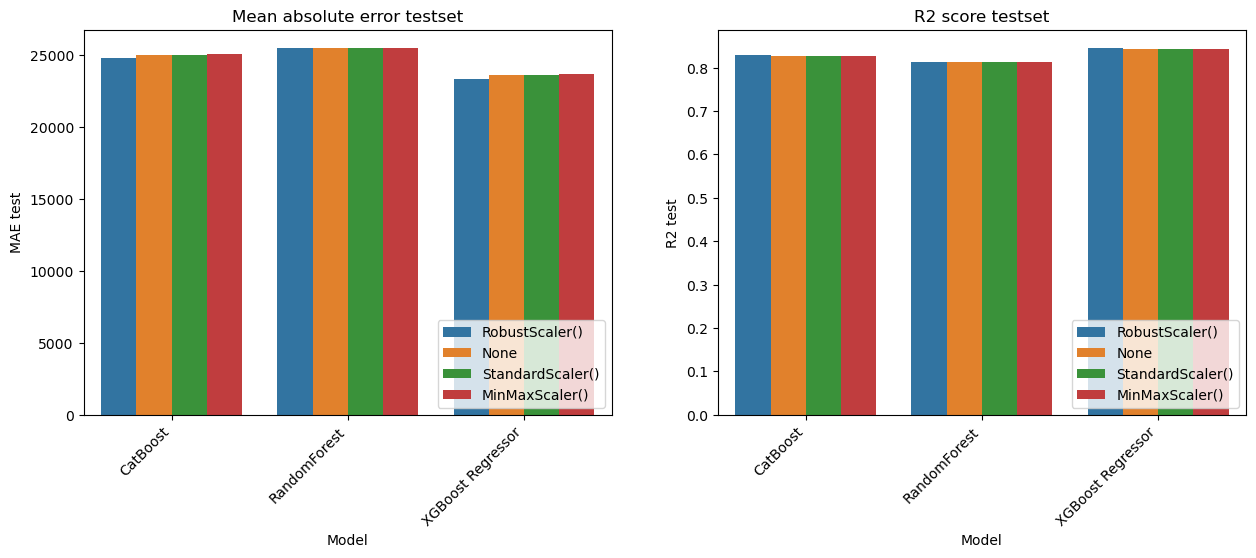

,Model,Scaler,RMSE train,RMSE test,R2 train,R2 test,MAE train,MAE test
2,XGBoost Regressor,RobustScaler(),2796.853887,44527.226874,0.999381,0.844804,356.461516,23307.635194
2,XGBoost Regressor,None,2796.462940,44880.864954,0.999381,0.842329,354.713688,23621.678524
2,XGBoost Regressor,StandardScaler(),2796.462940,44880.864954,0.999381,0.842329,354.713688,23621.678524
2,XGBoost Regressor,MinMaxScaler(),2796.504186,44941.382165,0.999381,0.841903,353.433728,23665.443497
1,CatBoost,RobustScaler(),2879.626406,46764.686216,0.999343,0.828815,632.448062,24757.065188
1,CatBoost,None,2914.828101,46927.306710,0.999327,0.827622,708.923463,24988.587945
1,CatBoost,StandardScaler(),2914.828101,46932.057966,0.999327,0.827587,708.923463,24988.666410
1,CatBoost,MinMaxScaler(),2892.944461,47045.879028,0.999337,0.826750,663.956891,25054.425428
0,RandomForest,StandardScaler(),29409.231086,48982.805132,0.931512,0.812191,16629.035651,25440.631508
0,RandomForest,MinMaxScaler(),29407.379066,48988.763648,0.931520,0.812145,16628.914196,25444.230867


In [23]:
non_res_result_optimized = print_results(non_res, models_tuned)
non_res_result_optimized

In [24]:
non_res_result_optimized.describe().T

,count,mean,std,min,25%,50%,75%,max
RMSE train,12.0,11701.180024,13076.259029,2796.462940,2796.766462,2903.886281,29403.835935,29409.231086
RMSE test,12.0,46905.253937,1787.461777,44527.226874,44926.252863,46929.682338,48984.294761,48997.104241
R2 train,12.0,0.976746,0.033398,0.931512,0.931537,0.999332,0.999381,0.999381
R2 test,12.0,0.827555,0.013121,0.812081,0.812179,0.827605,0.842010,0.844804
MAE train,12.0,5887.359054,7934.218799,353.433728,356.024559,686.440177,16627.470103,16629.795563
MAE test,12.0,24649.274459,843.609250,23307.635194,23654.502254,24988.627177,25441.531347,25451.554983


Tällä kertaa hyperparametrien optimoinnin jälkeen tulokset paranivat. Voittajaksi selviytyi XGBoost StandardScalerilla skaalattuna. MAE train 244, R2 train 0.999. MAE test 20039, R2 test 0.881. 

Parhaimmillaan MAE-arvo tippui 633, mikä ei prosentuaalisesti ole kovin hyvä parannus, mutta suunta on oikea. Hyperparametrien käyttö nosti R2 train ja R2 test erotusta keskimäärin, joka kertoo mallien olevan ylioppineempia. MAE-arvossa huonoimman ja parhaimman erotus oli 2182. 



<br><br><br>

## RES
Poikkeamien poiston jälkeen
- 509629 järjestelmää
- Keskihinta: 24669 $

#### Optimoimaton RES

Alkuperäisen DataFramen koko =  (573527, 27)
Siivotun DataFramen koko =  (514586, 27)
Keskihinta =  24734.959499672048


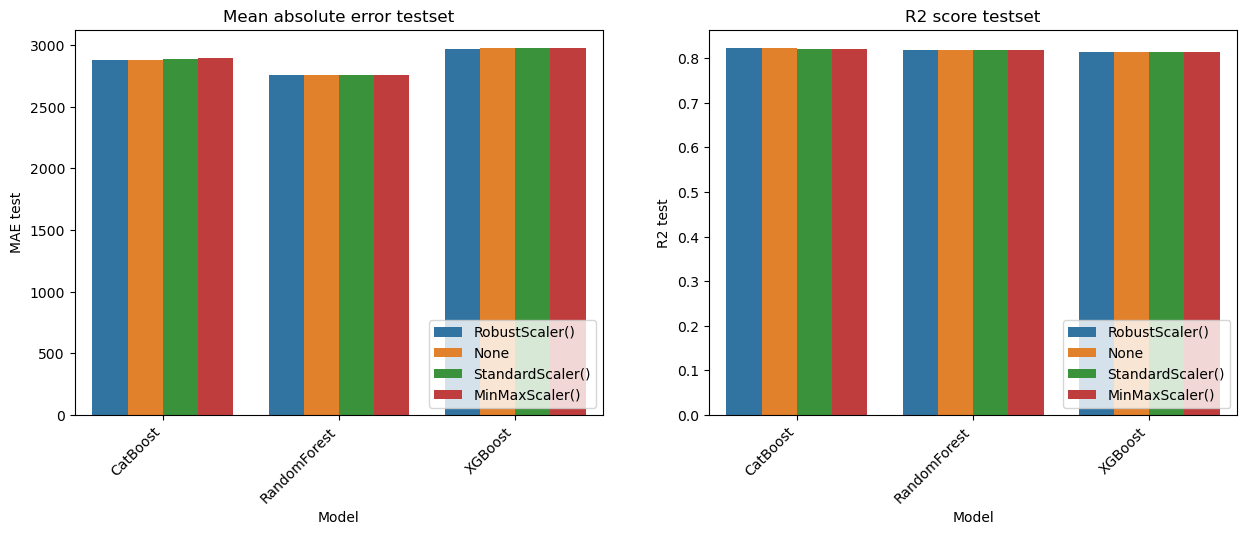

,Model,Scaler,RMSE train,RMSE test,R2 train,R2 test,MAE train,MAE test
2,CatBoost,RobustScaler(),4450.359203,4544.760882,0.830091,0.822710,2833.138955,2884.687785
2,CatBoost,None,4451.984103,4547.494559,0.829967,0.822497,2831.889742,2884.874534
2,CatBoost,StandardScaler(),4461.295168,4556.061645,0.829255,0.821827,2839.034004,2892.814356
2,CatBoost,MinMaxScaler(),4464.408043,4561.856790,0.829016,0.821374,2843.081694,2897.311635
0,RandomForest,RobustScaler(),1722.914248,4588.612778,0.974534,0.819272,1030.197332,2759.071896
0,RandomForest,None,1723.797490,4588.872714,0.974508,0.819252,1030.531057,2758.555748
0,RandomForest,MinMaxScaler(),1723.705108,4589.277847,0.974511,0.819220,1030.207368,2758.671823
0,RandomForest,StandardScaler(),1723.501793,4589.888270,0.974517,0.819172,1030.506608,2759.737813
1,XGBoost,RobustScaler(),4485.760792,4656.532619,0.827377,0.813882,2881.073891,2971.899388
1,XGBoost,None,4490.100615,4657.773848,0.827043,0.813783,2884.943270,2976.782227


In [25]:
res_result = print_results(res, models)
res_result

In [26]:
res_result.describe().T

,count,mean,std,min,25%,50%,75%,max
RMSE train,12.0,3556.502316,1353.851007,1722.914248,1723.774395,4456.639635,4486.845748,4490.100615
RMSE test,12.0,4599.723304,45.599873,4544.760882,4560.408004,4589.075280,4656.842926,4657.773848
R2 train,12.0,0.877075,0.071974,0.827043,0.827293,0.829611,0.974509,0.974534
R2 test,12.0,0.818379,0.003606,0.813783,0.813857,0.819236,0.821487,0.822710
MAE train,12.0,2250.374205,901.269123,1030.197332,1030.524944,2836.086479,2882.041236,2884.943270
MAE test,12.0,2874.830972,93.074134,2758.555748,2759.571334,2888.844445,2973.120097,2976.782227


Suurimmassa datasetissä ilman optimointiakin tulokset olivat erittäin hyviä. Paras algoritmi R2-scorella mitattuna oli CatBoost StandardScalerilla skaalattuna, MAE train 2756, R2 train 0.840. MAE test 2783, R2 test 0.836. Pieni ero R2-scoreissa kertoo hyvästä sovittumisesta. Myös XGboost sovittui hyvin, parhaimmillaan StandardScalerilla skaalattuna, MAE train 2798, R2 train 0.839. MAE test 2863, R2 test 0.829. 

MAE:lla mitattuna paras oli RandomForest MinMaxilla, MAE train 1001, R2 train 0.976. MAE test 2647, R2 test 0.835. RandomForest oli kuitenkin ylioppinut verrattuna muihin.

Keskimäärin R2-score oli 0.833, joka on erittäin hyvä tulos. MAE on keskimäärin n. 11 prosenttiyksikköä keskihinnasta, joka on siedettävä tarkkuus.  


#### Optimoitu RES

res_result_optimized = print_results(res, models_tuned)
res_result_optimized

In [28]:
res_result_optimized.describe().T

,count,mean,std,min,25%,50%,75%,max
RMSE train,12.0,4105.905368,813.715450,3454.016109,3480.150597,3647.019569,5202.659092,5202.732679
RMSE test,12.0,4643.261422,483.505331,4285.310601,4293.178854,4343.956190,5297.105947,5297.213353
R2 train,12.0,0.850168,0.061024,0.767785,0.767792,0.885895,0.896098,0.897653
R2 test,12.0,0.813102,0.039885,0.759144,0.759154,0.838030,0.841795,0.842374
MAE train,12.0,2636.918707,612.437769,2151.636176,2169.667988,2286.368774,3462.927529,3462.991829
MAE test,12.0,2943.167511,431.061138,2627.516964,2635.034412,2672.813153,3526.297500,3526.386512


Hyperparametrien optimoinnin jälkeen tulokset paranivat entisestään kaikilla muilla paitsi RandomForestilla. Parhaiten suoriutui CatBoost RoubustScalerilla, MAE train 2081, R2 train 0.905, MAE test 2525, R2 test 0.855. Hyperparametrien optimointi tehtiin tällä RES-datasetillä, joten odotetusti parhaat tulokset saavutettiin tällä datasetillä. XGBoostilla ja CatBoostilla MAE-arvot laskivat 200-300, ja R2 test nousi 2 %-yksikköä. RandomForestilla vastaavat huononivat optimoinnin jälkeen, MAE nousi n. 800 ja R2 test laski 6 %-yksikköä.

Tulokset olivat erittäin hyviä, koska tämä oli suurin ja tärkein datasetti. Datan esikäsittely ja muut vaiheet on tehty tämän datasetin ehdoilla ja jatkossa kehitettävä malli/sovellus tulee pohjautumaan pääasiassa tähän aineistoon. 


## Dataframen sarakkeiden optimointi

Koska varsinkin pienissä dataseteissä algoritmit olivat ylioppineita, koitetaan tätä ongelmaa parantaa vähentämällä ns."turhia" sarakkeita pois. RandomForest antoi default-hyperparametreillä parempia tuloksia, joten jatkossa käytetään sitä default-parametreillä. 

Päädyttiin käyttämään scalerina RobustScaleria, koska se oli paras CatBoostille edellissä testeissä ja erot eri scalereilla oli kuitenkin melko pieniä. Sarakkeiden karsimiseen käytetään RES-datasettiä, koska se on ns. päädatasetti.  

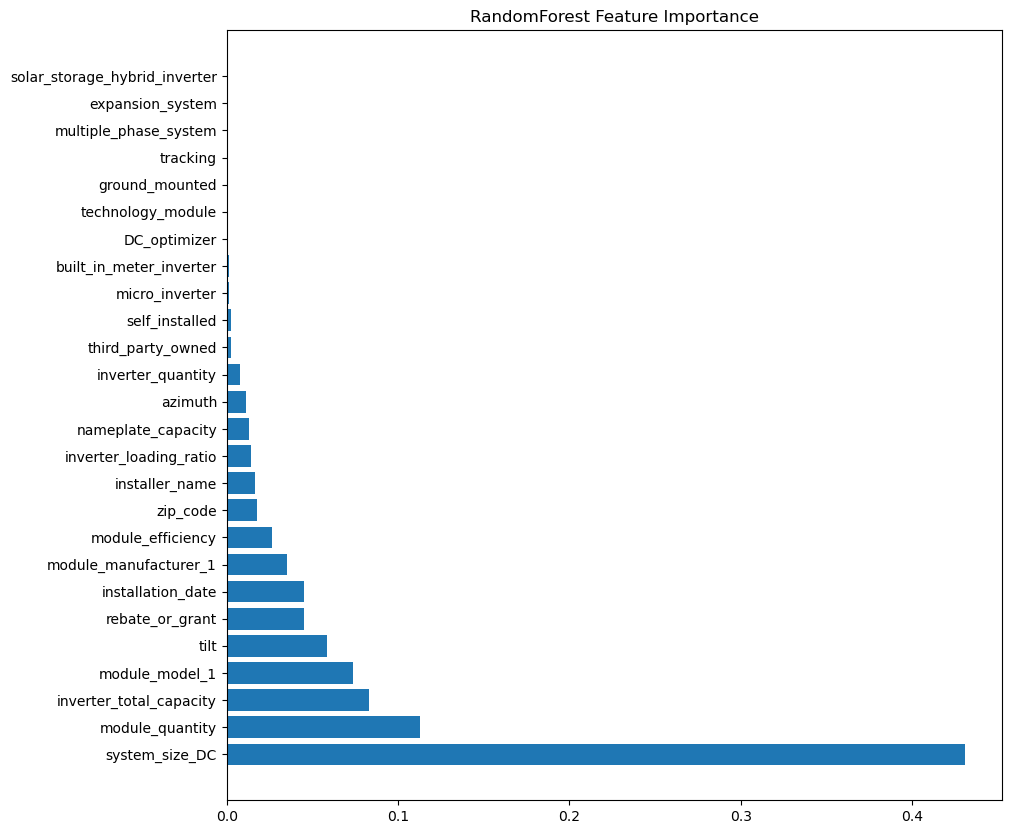

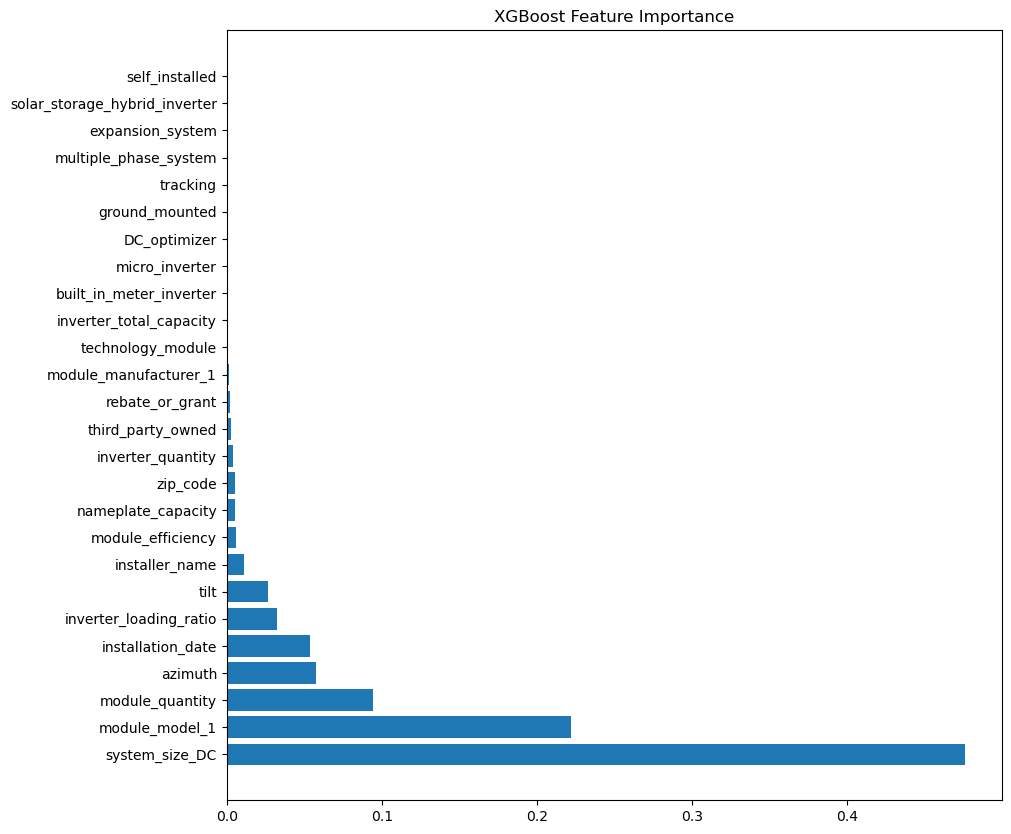

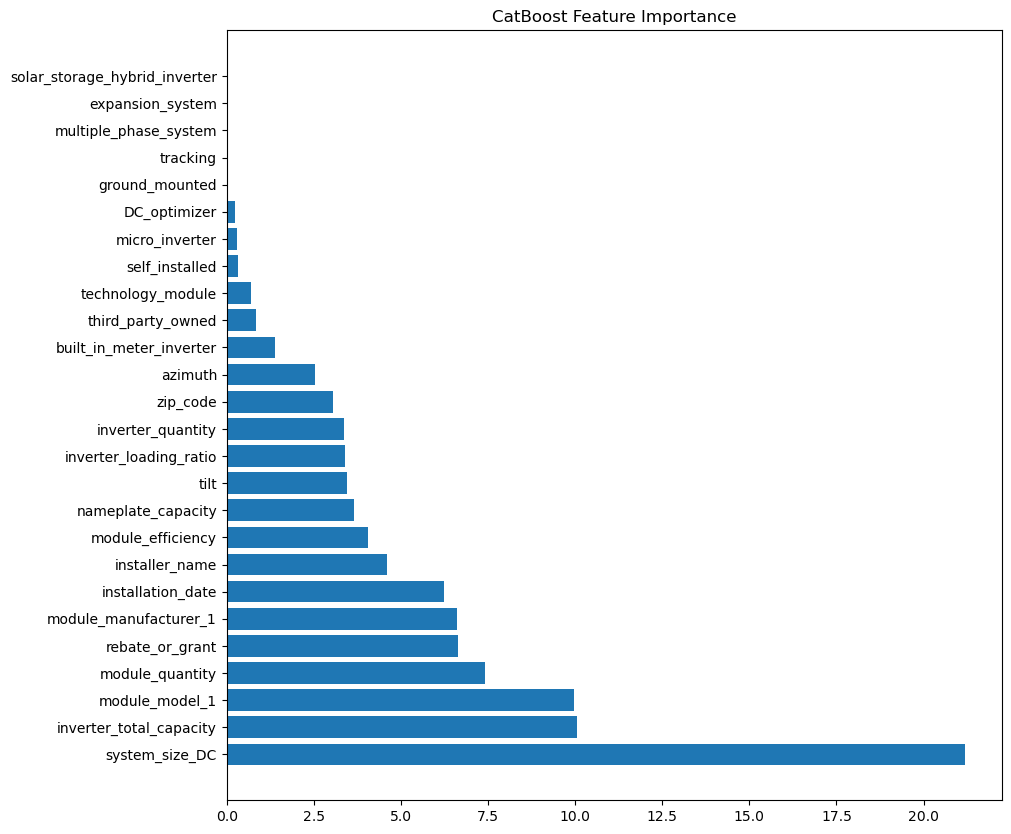

In [49]:
models_tuned = {"RandomForest": RandomForestRegressor(random_state=random_state),
            "CatBoost":CatBoostRegressor(random_seed = random_state, loss_function='RMSE', eval_metric ="MAE", verbose=False,subsample=0.5,learning_rate=0.3,l2_leaf_reg=10,iterations=1000,depth=10,border_count=200),
            "XGBoost Regressor": XGBRegressor(subsample=0.9,n_estimators=2000, max_depth=6,learning_rate=0.1,colsample_bytree= 0.7,colsample_bylevel=0.9,seed = random_state, tree_method="gpu_hist")           
            }
best_scaler = StandardScaler()
#print_results(res, models_tuned, scalers=scalers_list, importances = 1)
#print_results(res, models_tuned,importances=1)

features_df = res.sample(50)




y = features_df["total_installed_price"]
X = features_df.drop(columns="total_installed_price")

features = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state) 


    
    # Skaalataan data funktiokutsussa ilmoitetulla skaalaajalla



X_train = pd.DataFrame(best_scaler.fit_transform(X_train), columns=features)
X_test = pd.DataFrame(best_scaler.transform(X_test), columns=features)        


    
for name, model in models.items():
        

        model.fit(X_train,y_train)      


    
        # Jos importances == 1 käsitellään dataframen feature_importances ja piirretään niistä kuvaajat

        importances = model.feature_importances_
        sorted_importances = np.argsort(importances)[::-1]
        plt.figure(figsize=(10,10))
        plt.barh(X.columns[sorted_importances], importances[sorted_importances])
        plt.title(f"{name} Feature Importance")
        plt.show()







Tiputetaan valikoidut sarakkeet pois ja ajetaan parhaalla algoritmilla ja scalerilla vielä kaikki datasetit läpi

Alkuperäisen DataFramen koko =  (6057, 21)
Siivotun DataFramen koko =  (4416, 21)
Keskihinta =  34552.197284873124
Alkuperäisen DataFramen koko =  (11012, 20)
Siivotun DataFramen koko =  (6028, 20)
Keskihinta =  113145.6833012608
Alkuperäisen DataFramen koko =  (573527, 20)
Siivotun DataFramen koko =  (514586, 20)
Keskihinta =  24734.959499672048


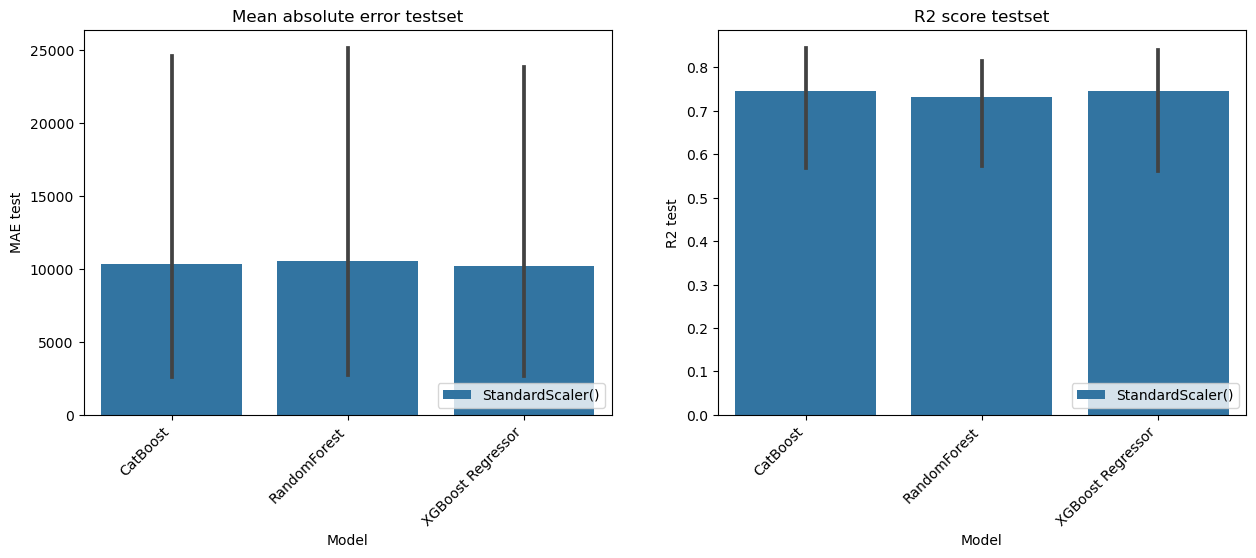

,DataFrame,Model,Scaler,RMSE train,RMSE test,R2 train,R2 test,MAE train,MAE test
1,res,CatBoost,StandardScaler(),3564.354928,4262.649471,0.891010,0.844037,2193.096506,2585.157159
2,res,XGBoost Regressor,StandardScaler(),3720.831714,4332.824432,0.881230,0.838860,2311.285208,2648.649175
2,res,XGBoost Regressor,StandardScaler(),3200.972835,46145.850063,0.999189,0.833315,512.979968,23849.381913
1,res,CatBoost,StandardScaler(),3397.501425,47170.054090,0.999086,0.825834,1024.614251,24573.623699
0,res,RandomForest,StandardScaler(),1792.218466,4635.574035,0.972444,0.815554,1054.128298,2760.919958
0,res,RandomForest,StandardScaler(),18094.159236,49430.413135,0.974075,0.808742,9579.018104,25116.784783
0,res,RandomForest,StandardScaler(),2464.201406,6044.194820,0.930653,0.572654,1534.647530,3812.379765
1,res,CatBoost,StandardScaler(),881.426943,6070.389753,0.991127,0.568942,475.595063,3938.080896
2,res,XGBoost Regressor,StandardScaler(),662.350995,6124.904913,0.994990,0.561165,235.857835,3998.586716


In [54]:
# Pudotetaan valitut kolumnit pois

columns_clean = ["tilt","azimuth","solar_storage_hybrid_inverter","expansion_system","multiple_phase_system", "tracking", "ground_mounted"]

res_bat_feat_optimized = exception_handling(res_bat.drop(columns=columns_clean),battery=1)
non_res_feat_optimized = exception_handling(non_res.drop(columns=columns_clean))
res_feat_optimized = exception_handling(res.drop(columns=columns_clean))

df_feat_list = {"res_bat":res_bat_feat_optimized,"non_res": non_res_feat_optimized,"res": res_feat_optimized}
df_name_list = ["res_bat", "non_res", "res"]

result_columns_list_feat = ["DataFrame","Model","Scaler","RMSE train","RMSE test","R2 train","R2 test","MAE train","MAE test"] 
scaler_best = StandardScaler()

result_feat_df = pd.DataFrame(columns=result_columns_list_feat)

for df_name, df_feat in df_feat_list.items():

    # Ajetaan eri skaalaajat evaluate_models funktion läpi

    data = evaluate_models(df_feat,scaler_best,models_tuned)
    result_feat_df = result_feat_df.append(data).sort_values(["R2 test","MAE test", "Model"],ascending=False)
    result_feat_df["DataFrame"] = df_name


        
# Piirretään kuvaaja
draw_graph(result_feat_df)
result_feat_df

# PITÄÄSKÖ TÄHÄNKIN RUNOILLA JOTAIN


### Neuroverkko testi



In [ ]:
# import tensorflow as tf


# from tensorflow.keras.layers import Dense
# from tensorflow.keras.layers import Dropout
# from tensorflow.keras import Sequential
# from tensorflow.keras.optimizers import Adam
# from keras.callbacks import EarlyStopping, LearningRateScheduler

# tf.random.set_seed(42)

In [ ]:

neural_results = pd.DataFrame(columns=["Optimizer","Epochs", "Batch size", "RMSE Train", "RMSE Test", "MAE Train", "MAE Test"])

res_clean = exception_handling(res)

y = np.array(res_clean["total_installed_price"])
X = np.array(res_clean.drop(columns="total_installed_price"))


# Alustetaan omat skaalaajat x:n ja y:n arvoille
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

# skaalataan arvot
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1,1))

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.33, random_state=random_state) 

shape_X = shape=X.shape[1]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

Alkuperäisen DataFramen koko =  (573527, 27)
Siivotun DataFramen koko =  (514586, 27)
Keskihinta =  24734.959499672048
(344772, 26)
(169814, 26)
(344772, 1)
(169814, 1)


In [ ]:
# Tämä funktio laskee optimizerin learning ratea pikkuhiljaa epochien edetessä

def scheduler(epoch):
	initial_lrate = 0.1
	drop = 0.5
	epochs_drop = 10.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate


In [ ]:
def deeplearning(model, optimizer, epochs, batch_size, callbacks=[],X_train = X_train, X_test=X_test, y_train=y_train,y_test=y_test, scaler_y=scaler_y):


    tulos = pd.DataFrame(columns=["Optimizer","Epochs", "Batch size", "RMSE Train", "RMSE Test", "MAE Train", "MAE Test"])

    model.compile(loss='mse', 
              optimizer=optimizer, 
              metrics=['mae'])


    #if len(callbacks) != 0:

    hist = model.fit(x=X_train, y=y_train, validation_split=0.25, epochs=epochs ,batch_size=batch_size ,verbose=0, callbacks=[callbacks])

    # Piirretään accuracy/loss kuvaaja
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(hist.history['mae'])
    plt.plot(hist.history['val_mae'])
    plt.title('model accuracy')
    plt.ylabel('mae')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.subplot(1,2,2)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()


    # Ajetaan evaluate funktio train ja test seteille
    results_train = model.evaluate(X_train,y_train,batch_size=batch_size)
    results_test = model.evaluate(X_test,y_test,batch_size=batch_size)

    # Skaalataan arvot takaisin alkuperäiseen skaalaan
    scaled_train = scaler_y.inverse_transform([results_train])
    scaled_test = scaler_y.inverse_transform([results_test])

    rmse_train = scaled_train[0,0]
    rmse_test = scaled_test[0,0]
    mae_train = scaled_train[0,1]
    mae_test = scaled_test[0,1]

    tulos.loc[len(tulos)] = [optimizer, epochs, batch_size, rmse_train, rmse_test, mae_train, mae_test]


    return tulos

In [ ]:
early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
learningrate = LearningRateScheduler(scheduler)

In [ ]:

model = Sequential()

model.add(Dense(64, input_dim=shape_X, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation="linear"))

model.summary()


Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_52 (Dense)            (None, 64)                1728      
                                                                 
 dense_53 (Dense)            (None, 128)               8320      
                                                                 
 dense_54 (Dense)            (None, 64)                8256      
                                                                 
 dense_55 (Dense)            (None, 32)                2080      
                                                                 
 dense_56 (Dense)            (None, 1)                 33        
                                                                 
Total params: 20,417
Trainable params: 20,417
Non-trainable params: 0
_________________________________________________________________


Restoring model weights from the end of the best epoch: 62.
Epoch 72: early stopping


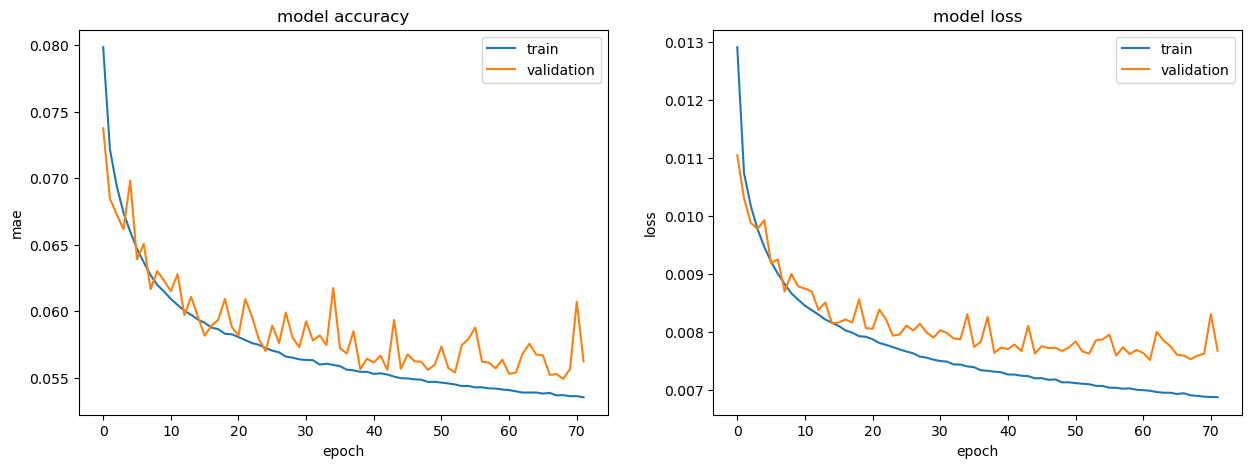

2654/2654 [==============================] - 5s 2ms/step - loss: 0.0074 - mae: 0.0552


,Optimizer,Epochs,Batch size,RMSE Train,RMSE Test,MAE Train,MAE Test,Callbacks
0,<keras.optimizers.optimizer_v2.adam.Adam objec...,100,128,2726.193053,2725.096452,9353.459137,9351.909951,[<keras.callbacks.EarlyStopping object at 0x00...
0,<keras.optimizers.optimizer_v2.adam.Adam objec...,100,128,2726.193053,2725.096452,9353.459137,9351.909951,[<keras.callbacks.EarlyStopping object at 0x00...
0,<keras.optimizers.optimizer_v2.adam.Adam objec...,100,128,1356.725445,1355.573645,5126.707886,5127.177797,[<keras.callbacks.EarlyStopping object at 0x00...
0,Adam,100,64,1064.376647,1093.449075,3705.880398,3802.526598,NaN


In [ ]:
callback = [early]

data = deeplearning(model, "Adam", 100, 64, callbacks=callback)

neural_results = neural_results.append(data)

neural_results


### Verkko numero 2
- Lasketaan verkon koko käyttämällä kaavaa: ```Training Data Samples / (Factor * (Input Neurons + Output Neurons))```


In [ ]:
sample_size = X.shape[0]
factor = 1
io_neurons = X.shape[1] + 1

size = round(sample_size/(factor*io_neurons))


model = Sequential()

model.add(Dense(size, input_dim=shape_X, activation='relu'))
model.add(Dense(1, activation="linear"))

model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_57 (Dense)            (None, 19059)             514593    
                                                                 
 dense_58 (Dense)            (None, 1)                 19060     
                                                                 
Total params: 533,653
Trainable params: 533,653
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callback = [early]

data = deeplearning(model, Adam(), 100, 128, callbacks=callback)

neural_results = neural_results.append(data)

neural_results

In [ ]:
# model = tf.keras.Sequential()
# model.add(tf.keras.Input(shape=X.shape[1],)))
# model.add(tf.keras.layers.Dense(30, activation="tanh"))

# model.add(tf.keras.layers.Dense(30, activation="tanh"))

# model.add(tf.keras.layers.Dense(30, activation="tanh"))

# model.add(tf.keras.layers'.Dense(1

# TÄNNE LISÄÄ TEKSTIÄ

### Neurovekko analyysiä
- Neuroverkko sai res_clean datasetin ajettua erittäin nopeaa läpi. Verrattuna Koneoppimisalgoritmeihin.
- Neuroverkossa arvojen skaalaamisella oli erittäin suuri vaikutus lopputulokseen. Mikä on luonnollista, koska eri neuronien väliset weight-arvot muuttuvat vähemmän.
- Viimmeisin neuroverkko sai MAE arvon 3653, mikä on samaa tasoa, mitä XGBoost ja Gradient Tree Boostingilla saadut MAE arvot ja huonompi mitä RandomForest
- RMSE = 5615.67503. Tämä on kanssa samaa suuruusluokkaa XGBoost ja Gradient Tree Boostingin kanssa ja huonompi mitä RandomForestilla.
- ROC kuvaajissa voidaan huomata, että Train Loss ja Accuracy pienenee melko jyrkästi, mutta validation loss ja accuracy poukkuoilee oudosti käyrän molemmilla puolilla, mikä ei ole optimaali tilanne. Tosin neuroverkkoa pitää vielä jatkokehittää.

In [ ]:
# Otetaan mallin painoarvot talteen
#model.save("models/model-v1.h5")

#### Jatkokehitysideoita

- Koska mallit tuntuivat olevan ylioppineita, siihen voisi mahdollisesti auttaa käytössä olevien sarakkeiden karsiminen, koska tällä hetkellä mukana on useita sarakkeita, jotka eivät hirveämmin vaikuta lopputulokseen